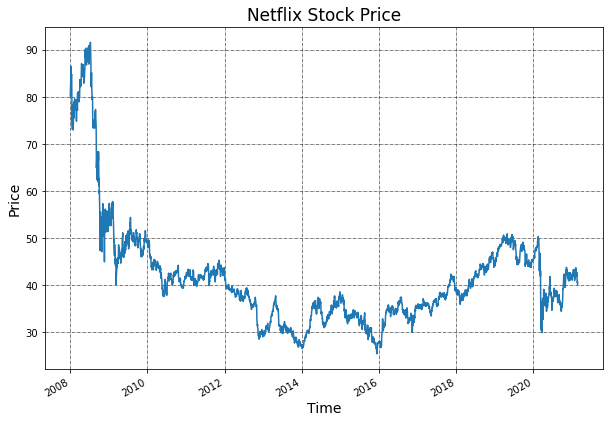

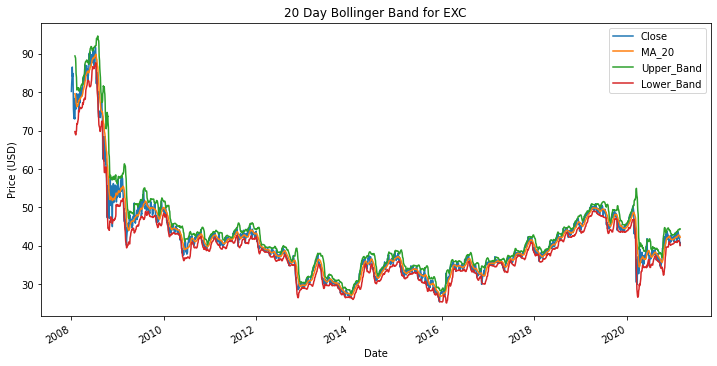

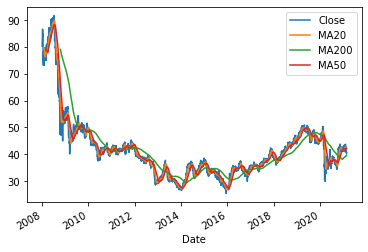

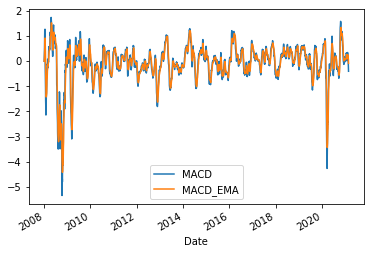

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries

%matplotlib inline

from datetime import datetime
import talib

from typing import TypeVar, Callable, Sequence
from functools import reduce
T = TypeVar('T')


from pylab import rcParams

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from keras.optimizers import RMSprop, SGD, Adam
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
%matplotlib inline

ALPHA_VANTAGE_API_KEY = '99RG1ZGZNWB4KLMX'
ts = TimeSeries(key= ALPHA_VANTAGE_API_KEY, output_format='pandas')

import pandas as pd
import pandas_datareader.data as web   
import datetime

start = datetime.datetime(2008,1,2)
end = datetime.datetime(2021,2,24)

#aae = web.DataReader("AAE", "yahoo", start, end)
#aae.to_csv('EXC.csv',index=False,header=True)

EXC = web.DataReader("EXC", "yahoo", start, end)
EXC.to_csv('EXC.csv',index=True,header=True)


EXC['Close'].plot(figsize=(10, 7))
plt.title("Netflix Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()
#收盘价

####
#此处要加四个图
####

QQQ, QQQ_info = ts.get_daily('QQQ', outputsize='full') 
QQQ = QQQ.rename(columns={'1. open' : 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'QQQ_Close', '5. volume': 'Volume' })
QQQ = QQQ.rename_axis(['Date'])
QQQ = QQQ.drop(columns=['Open', 'High', 'Low', 'Volume'])

QQQ = QQQ.sort_index(ascending=True, axis=0)
#slicing the data for 15 years from '2004-01-02' to today
QQQ = QQQ.loc['2008-01-02':]
QQQ

QQQ['QQQ(t-1)'] = QQQ.QQQ_Close.shift(periods=1)
QQQ['QQQ(t-2)'] =  QQQ.QQQ_Close.shift(periods=2)
QQQ['QQQ(t-5)'] =  QQQ.QQQ_Close.shift(periods=5)
QQQ


QQQ['QQQ_MA10'] = QQQ.QQQ_Close.rolling(window=10).mean()
#QQQ['QQQ_MA10_t'] = QQQ.QQQ_ClosePrev1.rolling(window=10).mean()
QQQ['QQQ_MA20'] = QQQ.QQQ_Close.rolling(window=20).mean()
QQQ['QQQ_MA50'] = QQQ.QQQ_Close.rolling(window=50).mean()



EXC['MA_20'] = EXC.Close.rolling(window=20).mean()
EXC['SD20'] = EXC.Close.rolling(window=20).std()
EXC['Upper_Band'] = EXC.Close.rolling(window=20).mean() + (EXC['SD20']*2)
EXC['Lower_Band'] = EXC.Close.rolling(window=20).mean() - (EXC['SD20']*2)
EXC.tail()

EXC[['Close', 'MA_20', 'Upper_Band', 'Lower_Band']].plot(figsize=(12,6))
plt.title('20 Day Bollinger Band for EXC')
plt.ylabel('Price (USD)')
plt.show();

EXC['EXC_Close(t-1)'] = EXC.Close.shift(periods=1)
EXC['EXC_Close(t-2)'] = EXC.Close.shift(periods=2)
EXC['EXC_Close(t-5)'] = EXC.Close.shift(periods=5)
EXC['EXC_Close(t-10)'] = EXC.Close.shift(periods=10)
EXC['EXC_Open(t-1)'] = EXC.Open.shift(periods=1)


EXC['MA5'] = EXC.Close.rolling(window=5).mean()
EXC['MA10'] = EXC.Close.rolling(window=10).mean()
EXC['MA20'] = EXC.Close.rolling(window=20).mean()
EXC['MA50'] = EXC.Close.rolling(window=50).mean()
EXC['MA200'] = EXC.Close.rolling(window=200).mean()

EXC[['Close', 'MA20', 'MA200', 'MA50']].plot()
plt.show()

EXC['EMA_12'] = EXC.Close.ewm(span=12, adjust=False).mean()
EXC['EMA_26'] = EXC.Close.ewm(span=26, adjust=False).mean()
EXC['MACD'] = EXC['EMA_12'] - EXC['EMA_26']

EXC['MACD_EMA'] = EXC.MACD.ewm(span=9, adjust=False).mean()

EXC[['MACD', 'MACD_EMA']].plot()
plt.show()




EXC['EMA10'] = EXC.Close.ewm(span=5, adjust=False).mean().fillna(0)
EXC['EMA20'] = EXC.Close.ewm(span=5, adjust=False).mean().fillna(0)
EXC['EMA50'] = EXC.Close.ewm(span=5, adjust=False).mean().fillna(0)
EXC['EMA100'] = EXC.Close.ewm(span=5, adjust=False).mean().fillna(0)
EXC['EMA200'] = EXC.Close.ewm(span=5, adjust=False).mean().fillna(0)




import talib

EXC['ATR'] = talib.ATR(EXC['High'].values, EXC['Low'].values, EXC['Close'].values, timeperiod=14)
EXC['ADX'] = talib.ADX(EXC['High'], EXC['Low'], EXC['Close'], timeperiod=14)
tp = (EXC['High'] + EXC['Low'] + EXC['Close']) /3
ma = tp/20 
md = (tp-ma)/20
EXC['CCI'] = (tp-ma)/(0.015 * md)

EXC['ROC'] = ((EXC['Close'] - EXC['Close'].shift(10)) / (EXC['Close'].shift(10)))*100

EXC['RSI'] = talib.RSI(EXC.Close.values, timeperiod=14)

EXC['William%R'] = talib.WILLR(EXC.High.values, EXC.Low.values, EXC.Close.values, 14) 

EXC['SO%K'] = ((EXC.Close - EXC.Low.rolling(window=14).min()) / (EXC.High.rolling(window=14).max() - EXC.Low.rolling(window=14).min())) * 100

EXC['per_change'] = EXC.Close.pct_change()
EXC['STD5'] = EXC.per_change.rolling(window=5).std()


SnP = web.DataReader("^GSPC", "yahoo", start, end)
SnP.to_csv('INX.csv',index=True,header=True)


#SnP, SnP_info = ts.get_daily('INX', outputsize='full') 
SnP = SnP.rename(columns={'1. open' : 'Open', '2. high': 'High', '3. low':'Low', 'Close': 'SnP_Close', '5. volume': 'Volume' })
SnP = SnP.rename_axis(['Date'])
SnP = SnP.drop(columns=['Open', 'High', 'Low', 'Volume'])

#sorting index
SnP = SnP.sort_index(ascending=True, axis=0)
#slicing the data for 15 years from '2004-01-02' to today
SnP = SnP.loc['2008-01-02':]
SnP

SnP['SnP(t-1))'] = SnP.SnP_Close.shift(periods=1)
SnP['SnP(t-5)'] =  SnP.SnP_Close.shift(periods=5)



EXC = EXC.merge(QQQ, left_index=True, right_index=True)
EXC = EXC.merge(SnP, left_index=True, right_index=True)
EXC = EXC.drop(columns=['MA_20', 'per_change', 'EMA_12', 'EMA_26'])
EXC['ForceIndex1'] = EXC.Close.diff(1) * EXC.Volume
EXC['ForceIndex20'] = EXC.Close.diff(20) * EXC.Volume
EXC['EXC_Close(t+1)'] = EXC.Close.shift(-1)

EXC = EXC.dropna()
EXC['Date_Col'] = EXC.index


from datetime import datetime

def extract_date_features(date_val):
    
    Day = date_val.day
    DayofWeek = date_val.dayofweek
    Dayofyear = date_val.dayofyear
    Week = date_val.week
    Is_month_end = date_val.is_month_end.real
    Is_month_start = date_val.is_month_start.real
    Is_quarter_end = date_val.is_quarter_end.real
    Is_quarter_start = date_val.is_quarter_start.real
    Is_year_end = date_val.is_year_end.real
    Is_year_start = date_val.is_year_start.real
    Is_leap_year = date_val.is_leap_year.real
    Year = date_val.year
    Month = date_val.month
    
    return Day, DayofWeek, Dayofyear, Week, Is_month_end, Is_month_start, Is_quarter_end, Is_quarter_start, Is_year_end, Is_year_start, Is_leap_year, Year, Month




funct = lambda x: pd.Series(extract_date_features(x))
EXC[['Day', 'DayofWeek', 'DayofYear', 'Week', 'Is_month_end', 'Is_month_start',
      'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Is_leap_year', 'Year', 'Month']] = EXC.Date_Col.apply(funct)



DJIA = web.DataReader("^DJI", "yahoo", start, end)
DJIA.to_csv('DJIA.csv',index=True,header=True)

#DJIA, DJIA_info = ts.get_daily('^DJI', outputsize='full') 
DJIA = DJIA.rename(columns={'Close': 'DJIA_Close' })
DJIA = DJIA.rename_axis(['Date'])
DJIA = DJIA.drop(columns=['Open', 'High', 'Low', 'Volume','Adj Close'])

#sorting index
DJIA = DJIA.sort_index(ascending=True, axis=0)
        #slicing the data for 15 years from '2004-01-02' to today

DJIA['DJIA(t-1))'] = DJIA.DJIA_Close.shift(periods=1)
DJIA['DJIA(t-5)'] =  DJIA.DJIA_Close.shift(periods=5)

EXC = EXC.merge(DJIA, left_index=True, right_index=True)

EXC.to_csv('EXC.csv')
